In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import numpy.ma as ma
import scipy.optimize as opt
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

import push_pull_amp as ppamp
import noise_models as noise

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

## Load Data

58877 / 58877


,WT_anti,ST_anti,SpT_anti,dataset,SpT_anti/ST_anti
0,735.501221,2355.609375,715.571350,u030,0.303773
1,335.676514,3260.783936,121.288528,sub_only,0.037196
2,879.217285,4071.139648,11.061405,kinase_dead,0.002717
3,158.169464,2345.656250,396.798187,u005,0.169163
4,316.239960,754.201721,217.337784,u005,0.288169
...,...,...,...,...,...
58872,94.453537,2375.045898,136.801575,u030,0.057600
58873,143.309418,2200.200684,729.940369,u005,0.331761
58874,5788.746094,2540.430664,87.660568,kinase_dead,0.034506
58875,2984.329834,14200.054690,8218.972656,u060,0.578799


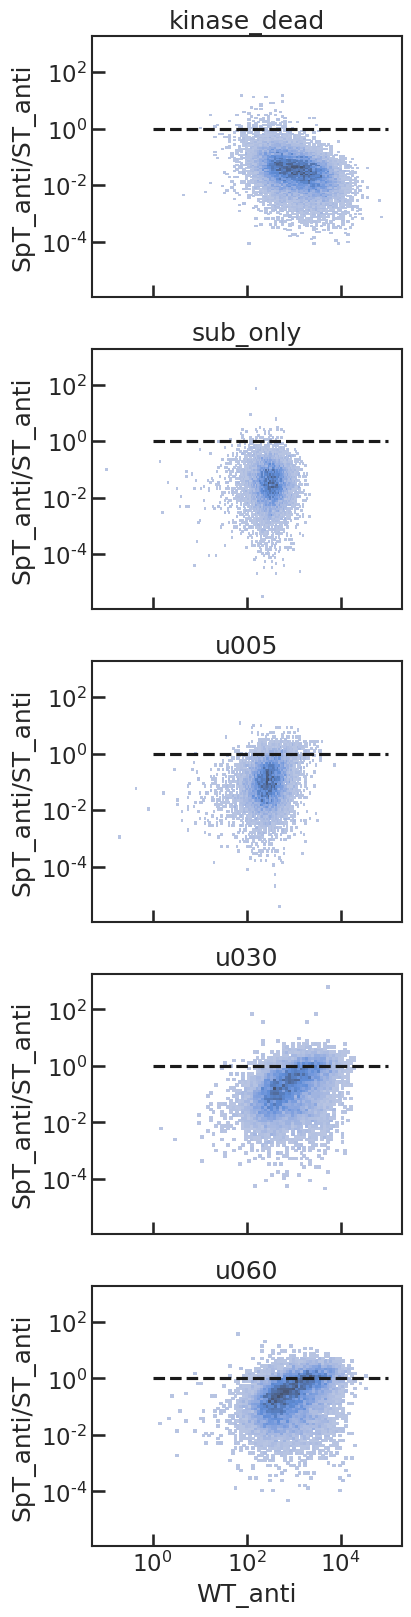

In [150]:
# df = pd.read_csv("../data/push/RR.csv")
# df = pd.read_csv("../data/push/EE(I).csv")
# df = pd.read_csv("../data/push/EE(L).csv")
# df = pd.read_csv("../data/push/EE(S).csv")
# df = pd.read_csv("../data/push/EE(E).csv")

df_list = []
df = pd.read_csv("../data/push/u5.csv")
df['dataset'] = 'u005'
df_list.append(df)
df = pd.read_csv("../data/push/u30.csv")
df['dataset'] = 'u030'
df_list.append(df)
df = pd.read_csv("../data/push/u60.csv")
df['dataset'] = 'u060'
df_list.append(df)
df = pd.read_csv("../data/push/u100.csv")
df['dataset'] = 'u100'
df_list.append(df)
df = pd.read_csv("../data/push/Substrate only.csv")
df['dataset'] = 'sub_only'
df_list.append(df)

df = pd.read_csv("../data/push/Kinase Dead.csv")
df['dataset'] = 'kinase_dead'
df_list.append(df)

df = pd.concat(df_list)


df = df[(df[df.columns[:-1]] >= 0).all(axis=1)].rename(columns={'Kinase': 'WT_anti', 'Substrate': 'ST_anti', 'Phosphorylation': 'SpT_anti'})


df = df.sample(frac=1.0, replace=False, random_state=776)

df.reset_index(inplace=True, drop=True)

df['SpT_anti/ST_anti'] = df['SpT_anti'] / df['ST_anti']


print(len(df.index), "/", len(df.index))

display(df)


ndatasets = df.groupby("dataset").ngroups
fig, axes = plt.subplots(ndatasets, 1, figsize=(4, 4*ndatasets),
                        sharex=True, sharey=True)

for i, (dataset, group) in enumerate(df.groupby("dataset")):
    
    sns.histplot(group, x='WT_anti', y='SpT_anti/ST_anti', 
                 log_scale=(True, True), ax=axes[i])
    
    axes[i].hlines(1e0, xmin=1e0, xmax=1e5, color='k', linestyle='--')
    axes[i].set_title(dataset)

plt.show()


## Resample from Noise Models

,Flag Antibody,GFP - Area
0,187.686859,5196.793457
1,355.473175,9603.830078
2,41.772331,4211.423340
3,106.623306,586.752930
4,251.056992,17206.781250
...,...,...
22005,819.340881,26279.457030
22006,217.897446,5552.517090
22007,172.323105,3148.043213
22008,2958.141602,99144.625000


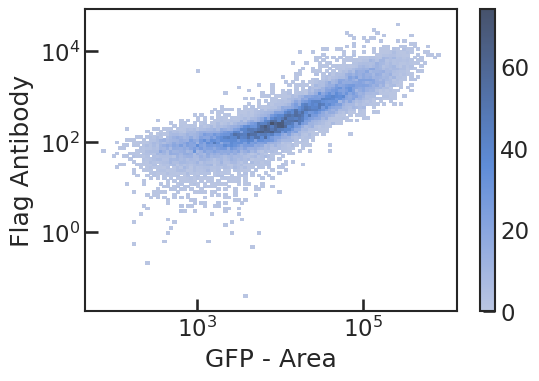

kinase_dead
sub_only
u005
u030
u060


,Myc Antibody,GFP - Area
0,350.844482,3913.260498
1,1327.086426,14438.492190
2,833.156799,9002.547852
3,415.282654,3438.784180
4,260.497681,3944.230713
...,...,...
21933,88.697136,369.316315
21934,174.043274,3317.098389
21935,217.648987,2090.604736
21936,1159.802124,10384.017580


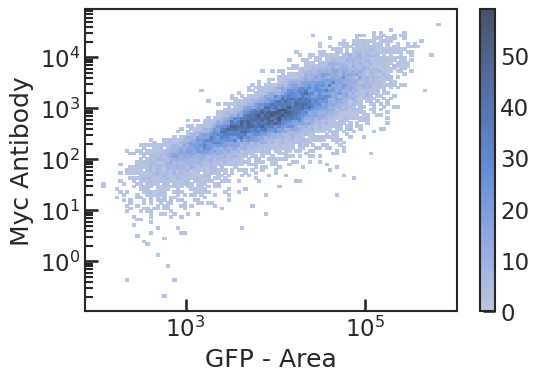

kinase_dead
sub_only
u005
u030
u060
58877
58672


,WT_anti,ST_anti,SpT_anti,dataset,SpT_anti/ST_anti,WT_GFP,ST_GFP
0,735.501221,2355.609375,715.571350,u030,0.303773,48183.545355,18668.498471
1,335.676514,3260.783936,121.288528,sub_only,0.037196,5564.028499,17117.196777
2,879.217285,4071.139648,11.061405,kinase_dead,0.002717,123171.870794,37370.021749
3,158.169464,2345.656250,396.798187,u005,0.169163,6111.539519,7188.945491
4,316.239960,754.201721,217.337784,u005,0.288169,11789.070753,14390.608318
...,...,...,...,...,...,...,...
58872,94.453537,2375.045898,136.801575,u030,0.057600,4198.609752,15694.804054
58873,143.309418,2200.200684,729.940369,u005,0.331761,1239.392572,14390.608318
58874,5788.746094,2540.430664,87.660568,kinase_dead,0.034506,163228.268370,48478.992581
58875,2984.329834,14200.054690,8218.972656,u060,0.578799,102091.357977,211864.530896


In [151]:
nbins_anti = 100
nbins_gfp = 100

writer_noise = noise.EmpNoiseModel("../data/Kinase Noise.csv", 
                                   'Flag Antibody', 'GFP - Area', 
                                   nbins_anti=nbins_anti, nbins_gfp=nbins_gfp, 
                                   verbose=True)
writer_noise.plot()

for dataset, group in df.groupby("dataset"):
    
    print(dataset)
    
    df.loc[group.index, 'WT_GFP'] = writer_noise.anti_to_GFP(group['WT_anti'], 
                                                             plot=False)
    
    
substrate_noise = noise.EmpNoiseModel("../data/Substrate Noise.csv", 
                                   'Myc Antibody', 'GFP - Area', 
                                   nbins_anti=nbins_anti, nbins_gfp=nbins_gfp, 
                                   verbose=True)
substrate_noise.plot()

for dataset, group in df.groupby("dataset"):
    
    print(dataset)
    
    df.loc[group.index, 'ST_GFP'] = substrate_noise.anti_to_GFP(group['ST_anti'], 
                                                                plot=False)



print(len(df))
df.dropna(inplace=True)
print(len(df))

display(df)

In [152]:
def solve(models, verbose=False):

    if verbose:
        start = time.time()

    def loss(x, args):
        
#         print(x)

        (logalphaWS, logvWSp, logvbgp, Sigma2, A) = x
        (models) = args

        loss = 0.0
        norm = 0.0
        for dataset in models:
            model = models[dataset]
            N_data = model.N_data
            
            norm += N_data
            
            if isinstance(model, ppamp.Push):
                loss += N_data * model.loss(
                    np.array([10**logalphaWS, 10**logvWSp, 10**logvbgp]), 
                    np.array([Sigma2, A, 0.0]))
            elif isinstance(model, ppamp.Background):
                loss += N_data * model.loss(
                    np.array([10**logvbgp]), 
                    np.array([Sigma2, A, 0.0]))
        
        loss /= norm
        
        return loss

    x0 = (3.0, 1.0, 0.0, 0.05, 1.0)
    bounds = [(None, None), (None, None), (None, None), 
              (0.0, None), (0.0, None)]

    if verbose:
        print("Initial Loss:", loss(x0, (models)))


    res = opt.minimize(loss, x0, args=(models,), method='L-BFGS-B', 
                       jac='2-point', bounds=bounds, 
                       options={'iprint':101, 'eps': 1e-8, 
                                'gtol': 1e-8, 'ftol':1e-12})
    

    if verbose:
        print("Final Loss:", res.fun)

        end = time.time()

        print("Time Elapsed", end-start, "seconds")

        print(res)
        
    
    return res


In [153]:
models = {}

for dataset, group in df.groupby("dataset"):
    
    if dataset == "kinase_dead":
        model = ppamp.Background()
        model.set_data(group['ST_GFP'].values.copy(), 
                       group['SpT_anti'].values.copy())
                
    else:
        model = ppamp.Push()
        model.set_data(group['WT_GFP'].values.copy(),
                       group['ST_GFP'].values.copy(), 
                       group['SpT_anti'].values.copy())
                
    models[dataset] = model
    
res = solve(models, verbose=True)


Initial Loss: 46.16148530651347
Final Loss: 0.03353679437530215
Time Elapsed 3.7919914722442627 seconds
      fun: 0.03353679437530215
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.61719885e-10,  5.16884029e-08,  4.96685562e-09, -8.24220479e-08,
       -6.41681254e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 348
      nit: 47
     njev: 58
   status: 0
  success: True
        x: array([ 2.70192956, -0.38781061, -1.78132104,  0.39340074,  0.68035325])


Model parameters:
$\log_{10}(\alpha_{WS})$ 503.4189515322075
$\log_{10}(v_{WS}^p)$ 0.40943917169831695
$\log_{10}(v_{bg}^p)$ 0.01654546420072688
Noise parameters
$\Sigma^2$ 0.3934007386420078
$A$ 0.6803532533108237


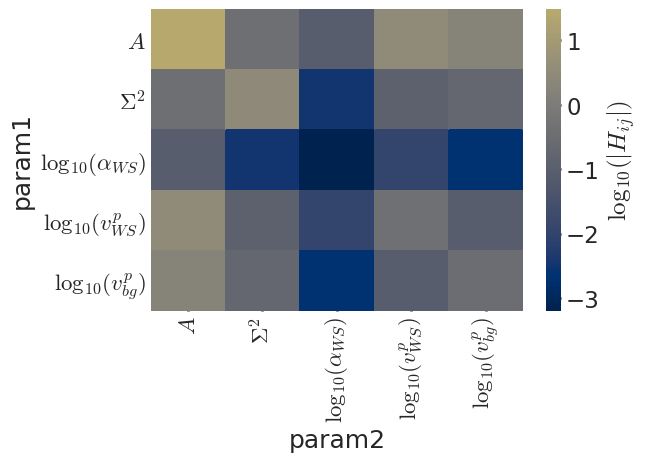

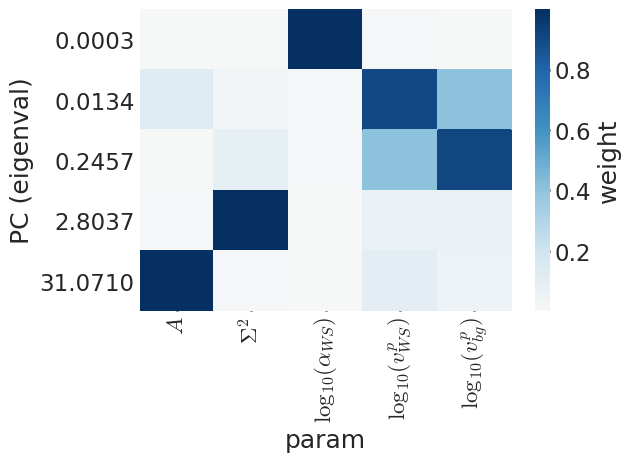

In [154]:
hess = la.inv(res.hess_inv.todense())
param_labels = [r"$\log_{10}(\alpha_{WS})$", r"$\log_{10}(v_{WS}^p)$", r"$\log_{10}(v_{bg}^p)$", r"$\Sigma^2$", r"$A$"]

print("Model parameters:")
for i in range(3):
    print(param_labels[i], 10**res.x[i])

print("Noise parameters")
for i in range(3, 5):
    print(param_labels[i], res.x[i])
    


s_list = []

for i, labeli in enumerate(param_labels):
    for j, labelj in enumerate(param_labels):
        s_list.append([labeli, labelj, np.log10(np.abs(hess[i, j]))])

df_hess = pd.DataFrame(s_list, columns=['param1', 'param2', 'hess'])
sns.heatmap(df_hess.pivot("param1", "param2", "hess"), 
            cbar_kws={'label': r"$\log_{10}(|H_{ij}|)$"}, 
            cmap='cividis', center=0)

plt.show()

evals, evecs = la.eigh(hess)

evals = evals[::-1]
evecs = evecs[:, ::-1]

s_list = []
for i, labeli in enumerate(param_labels):
    for j in range(len(evals)):
        s_list.append([labeli, "{:.4f}".format(evals[j]), np.abs(evecs[i, j])])

df_evecs = pd.DataFrame(s_list, columns=['param', "PC (eigenval)", 'val'])
sns.heatmap(df_evecs.pivot("PC (eigenval)", "param", "val"), 
            cbar_kws={'label': "weight"}, 
            cmap='RdBu', center=0)

plt.show()

In [155]:
(logalphaWS, logvWSp, logvbgp, Sigma2, A) = res.x

for dataset in models:
    model = models[dataset]
    
    if isinstance(model, ppamp.Push):
        SpT_GFP_predict = model.predict_all(
            np.array([10**logalphaWS, 10**logvWSp, 10**logvbgp]))
    elif isinstance(model, ppamp.Background):
        SpT_GFP_predict = model.predict_all(
            np.array([10**logvbgp]))
        
    df.loc[df[df.dataset==dataset].index, 'SpT_GFP_predict'] = SpT_GFP_predict
    
    
ST_noise = noise.LogNormNoiseModel(Sigma2=Sigma2, A=A, B=0.0)

df['SpT_anti_predict'] = ST_noise.GFP_to_anti(df['SpT_GFP_predict'])

df['SpT_GFP_predict/ST_GFP'] = df['SpT_GFP_predict'] / df['ST_GFP']
df['SpT_anti_predict/ST_anti'] = df['SpT_anti_predict'] / df['ST_anti']

display(df)

,WT_anti,ST_anti,SpT_anti,dataset,SpT_anti/ST_anti,WT_GFP,ST_GFP,SpT_GFP_predict,SpT_anti_predict,SpT_GFP_predict/ST_GFP,SpT_anti_predict/ST_anti
0,735.501221,2355.609375,715.571350,u030,0.303773,48183.545355,18668.498471,5514.149940,523.360673,0.295372,0.222176
1,335.676514,3260.783936,121.288528,sub_only,0.037196,5564.028499,17117.196777,2156.987961,546.255043,0.126013,0.167523
2,879.217285,4071.139648,11.061405,kinase_dead,0.002717,123171.870794,37370.021749,608.240732,45.509413,0.016276,0.011179
3,158.169464,2345.656250,396.798187,u005,0.169163,6111.539519,7188.945491,1659.264072,39.568027,0.230808,0.016869
4,316.239960,754.201721,217.337784,u005,0.288169,11789.070753,14390.608318,3438.401426,233.965647,0.238934,0.310216
...,...,...,...,...,...,...,...,...,...,...,...
58872,94.453537,2375.045898,136.801575,u030,0.057600,4198.609752,15694.804054,1700.919341,45.049048,0.108375,0.018968
58873,143.309418,2200.200684,729.940369,u005,0.331761,1239.392572,14390.608318,691.955915,10.745590,0.048084,0.004884
58874,5788.746094,2540.430664,87.660568,kinase_dead,0.034506,163228.268370,48478.992581,789.052201,3.708045,0.016276,0.001460
58875,2984.329834,14200.054690,8218.972656,u060,0.578799,102091.357977,211864.530896,37195.060406,1117.410254,0.175561,0.078691


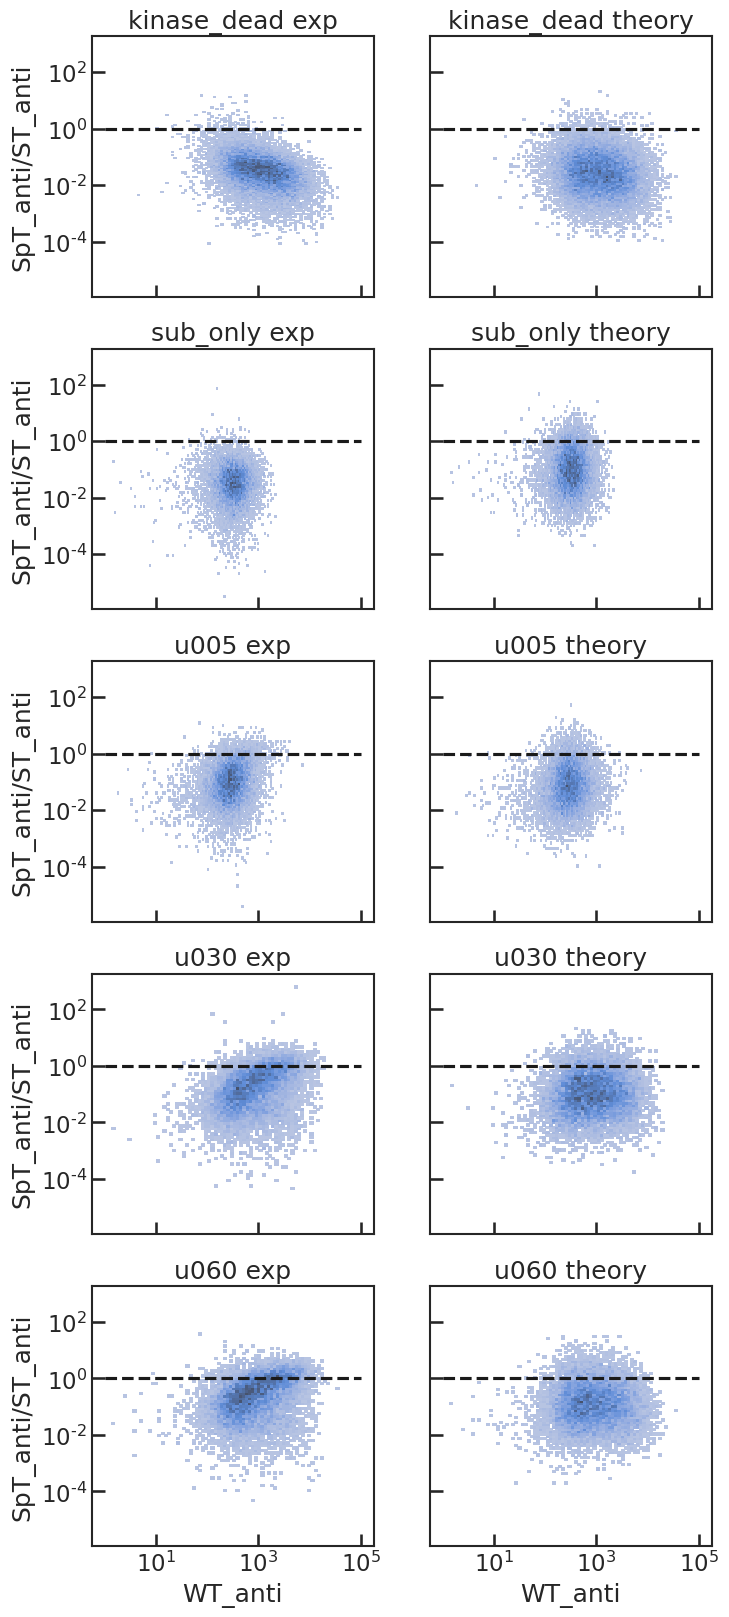

In [179]:
ndatasets = df.groupby("dataset").ngroups
fig, axes = plt.subplots(ndatasets, 2, figsize=(8, 4*ndatasets),
                        sharex=True, sharey=True)

for i, (dataset, group) in enumerate(df.groupby("dataset")):
    
    sns.histplot(group, x='WT_anti', y='SpT_anti/ST_anti', 
                 log_scale=(True, True), ax=axes[i, 0])
    sns.histplot(group, x='WT_anti', y='SpT_anti_predict/ST_anti', 
                 log_scale=(True, True), ax=axes[i, 1])
    
    axes[i, 0].hlines(1e0, xmin=1e0, xmax=1e5, color='k', linestyle='--')
    axes[i, 1].hlines(1e0, xmin=1e0, xmax=1e5, color='k', linestyle='--')
    axes[i, 0].set_title("{0:} {1:}".format(dataset, "exp"))
    axes[i, 1].set_title("{0:} {1:}".format(dataset, "theory"))
    
    model = models[dataset]
    
    ST_list = [1e0, 1e2, 1e4, 1e6]
    
    
#     palette = iter(sns.color_palette("Reds", len(ST_list)))
#     for ST in ST_list:
#         WT = np.logspace(0.0, 5.0, 100)
        
#         if dataset == 'kinase_dead':
            
#             model.set_data(ST*np.ones_like(WT), np.array([]))
#             SpT_predict = model.predict_all(
#                 np.array([10**logvbgp]))
            
#             color = next(palette)
#             axes[i, 0].plot(WT, SpT_predict/ST, '-', 
#                             color=color, lw=1.5)
#             axes[i, 1].plot(WT, SpT_predict/ST, '-', 
#                             color=color, lw=1.5)
            
#         else:
#             model.set_data(WT, ST*np.ones_like(WT), np.array([]))
#             SpT_predict = model.predict_all(
#                 np.array([10**logalphaWS, 10**logvWSp, 10**logvbgp]))
            
#             color = next(palette)
#             axes[i, 0].plot(WT, SpT_predict/ST, '-', 
#                             color=color, lw=1.5)
#             axes[i, 1].plot(WT, SpT_predict/ST, '-', 
#                             color=color, lw=1.5)
plt.show()

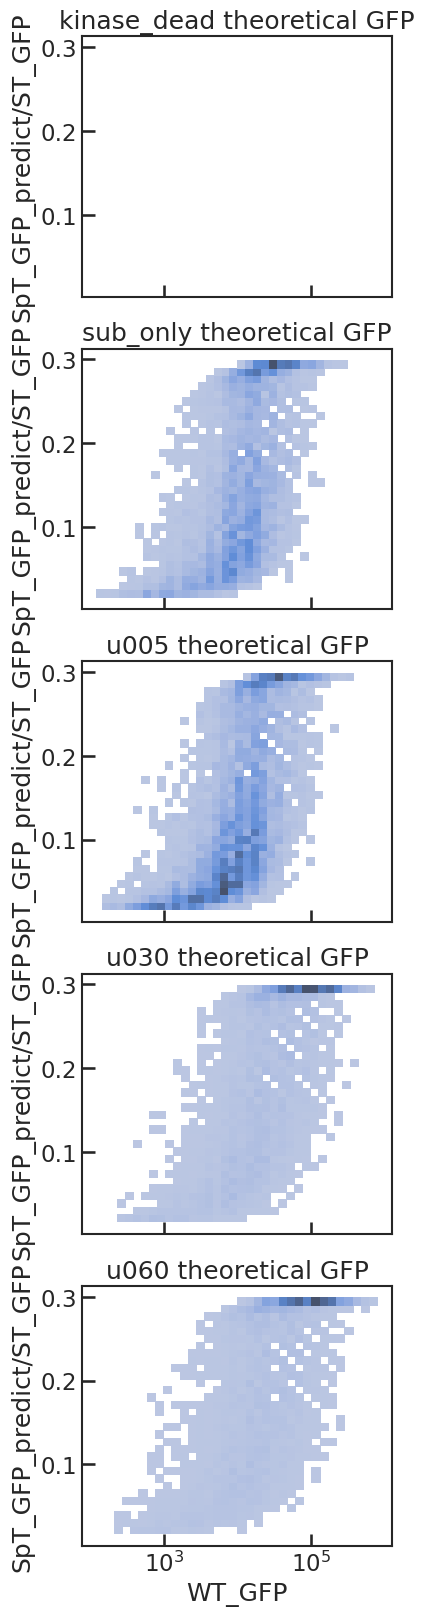

In [180]:
ndatasets = df.groupby("dataset").ngroups
fig, axes = plt.subplots(ndatasets, 1, figsize=(4, 4*ndatasets),
                        sharex=True, sharey=True)

for i, (dataset, group) in enumerate(df.groupby("dataset")):
    
    sns.histplot(group, x='WT_GFP', y='SpT_GFP_predict/ST_GFP', 
                 log_scale=(True, False), ax=axes[i], bins=32)
    
    axes[i].set_title("{0:} {1:}".format(dataset, "theoretical GFP"))
#     axes[i].set_ylim(0, 1)

plt.show()

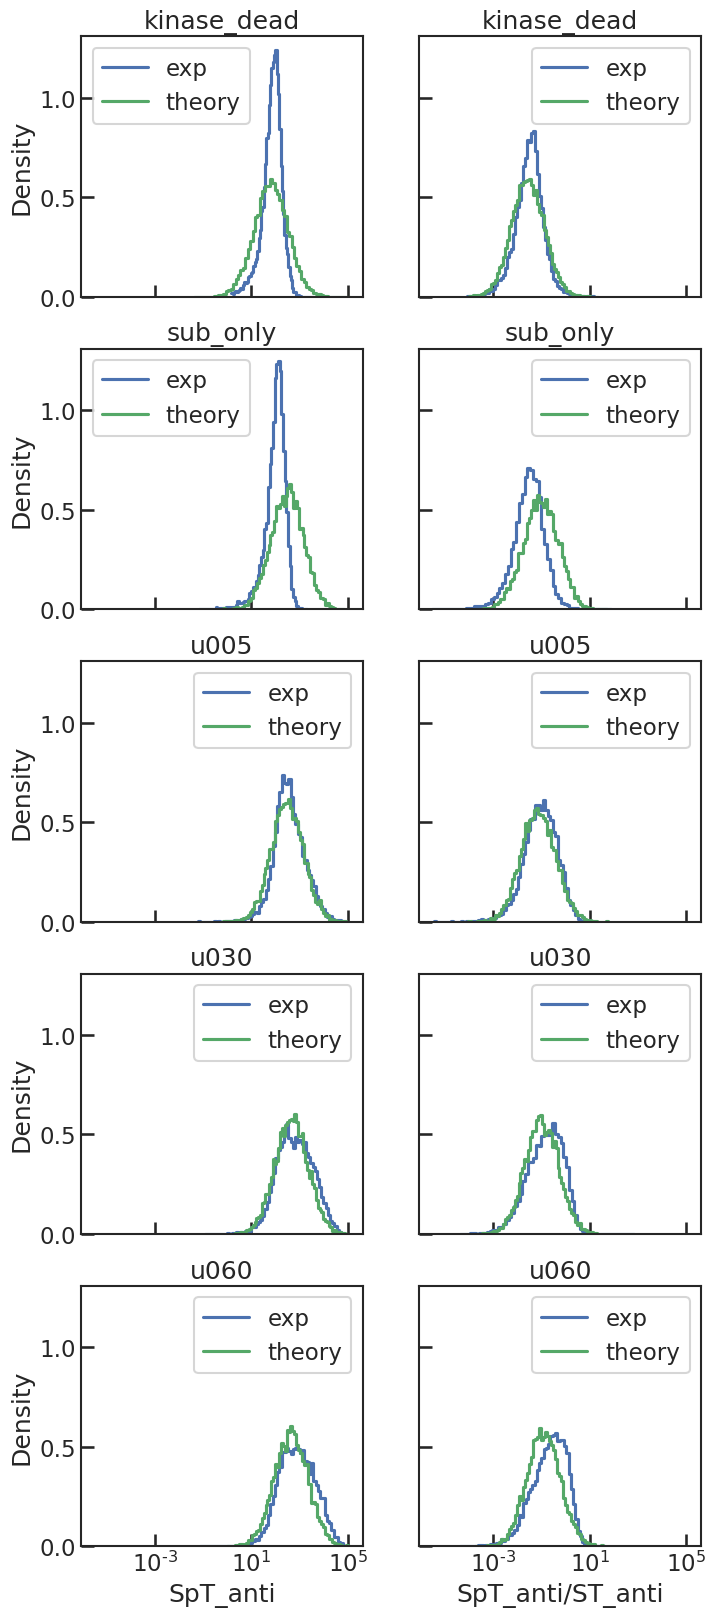

In [181]:
ndatasets = df.groupby("dataset").ngroups
fig, axes = plt.subplots(ndatasets, 2, figsize=(8, 4*ndatasets),
                        sharex=True, sharey=True)

for i, (dataset, group) in enumerate(df.groupby("dataset")):
    
    sns.histplot(group, x='SpT_anti', 
                 log_scale=True, ax=axes[i, 0], label="exp", bins=64,
                 element="step", fill=False, stat='density')
    sns.histplot(group, x='SpT_anti_predict', 
                 log_scale=True, ax=axes[i, 0], label="theory", color='g', bins=64,
                 element="step", fill=False, stat='density')
    
    axes[i, 0].set_title(dataset)
    axes[i, 0].legend()
    
    sns.histplot(group, x='SpT_anti/ST_anti', 
                 log_scale=True, ax=axes[i, 1], label="exp", bins=64,
                 element="step", fill=False, stat='density')
    sns.histplot(group, x='SpT_anti_predict/ST_anti', 
                 log_scale=True, ax=axes[i, 1], label="theory", color='g', bins=64,
                 element="step", fill=False, stat='density')
    
    axes[i, 1].set_title(dataset)
    axes[i, 1].legend()

plt.show()